# Predicting Stock Price of KAKAO corp, using LSTM

* LSTM으로 주가 예측하기를 심화 과정으로 수행한다.
* 시가, 종가, 고가, 저가, 거래량의 기존 정보에 더하여, 미국 국채 금리, 지수 등을 포함한다.

* 필요한 Library
    * beautifulsoup
        * 웹에 있는 데이터를 추출(크롤링)하기 위한 모듈 [[ref]](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
        * conda install beautifulsoup4
    * request
        * 웹에 있는 데이터를 추출(크롤링)하기 위한 모듈 [[ref]](https://www.daleseo.com/python-requests/)
        * conda install requests
    * yfinance :
        * yahoo finance에서 주가 및 지수 정보 불러오기 [[ref]](https://github.com/ranaroussi/yfinance)
        * conda install yfinance
    * yahoo_fin :
        * yahoo finance에서 재무정보 불러오기 [[ref]](http://theautomatic.net/yahoo_fin-documentation/)
        * pip3 install yahoo-fin
    * fbprophet : 
        * 시계열 데이터로 예측을 하기 위한 모듈 [[ref]](https://facebook.github.io/prophet/)
        * pip3 install fbprophet
    * pandas_datareader 
        * 웹 상의 데이터를 DataFrame 객체로 만드는 함수를 포함하는 모듈 [[ref]](https://pandas-datareader.readthedocs.io/en/latest/)
        * pip3 install pandas_datareader
    * pandas, numpy, seaborn, sklearn, tensorflow

* Reference
    * https://blog.naver.com/PostView.naver?blogId=cflab&logNo=222142254914&redirect=Dlog&widgetTypeCall=true&directAccess=false
    * https://blog.naver.com/PostView.naver?blogId=cflab&logNo=222142254914&redirect=Dlog&widgetTypeCall=true&directAccess=false
    * https://cocoabba.tistory.com/20
    * https://rednooby.tistory.com/98
    * https://beomi.github.io/gb-crawling/posts/2017-01-20-HowToMakeWebCrawler.html
    * https://dschloe.github.io/python/python_edu/07_deeplearning/deep_learning_lstm/
    * https://bziwnsizd.tistory.com/33
    * https://coding-yoon.tistory.com/131
    * https://colab.research.google.com/github/teddylee777/machine-learning/blob/master/04-TensorFlow2.0/01-%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90-%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1/02-LSTM-stock-forecasting-with-LSTM-financedatareader.ipynb
    * https://dataplay.tistory.com/19
    * https://github.com/KerasKorea/KEKOxTutorial/blob/master/22_Keras%EB%A5%BC%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%EC%A3%BC%EC%8B%9D%20%EA%B0%80%EA%B2%A9%20%EC%98%88%EC%B8%A1.md
    * https://www.youtube.com/watch?v=LLLVYkXJw30&t=843s
    * https://www.youtube.com/watch?v=9haME49Rx_0&t=120s

In [1]:
import os, sys  
from google.colab import drive  
drive.mount('/content/drive', force_remount=True)   
pg_path = '/content/packages'  
#os.symlink('/content/drive/My Drive/Colab Notebooks', pg_path)  
sys.path.insert(0, pg_path)  
# !pip install --target=$pg_path yfinance
# !pip install --target=$pg_path pingouin


Mounted at /content/drive


In [2]:
!pip install --target=$pg_path yfinance, pingouin

ERROR: Invalid requirement: 'yfinance,'


In [3]:
# unitility
import os, warnings
from copy import deepcopy
from datetime import datetime
# from urllib.request import urlopen
# import urllib.request as urllib


# crawling
# import requests
# from bs4 import BeautifulSoup

# stock price data load
import yfinance as yf
# import yahoo_fin as yff
# import yahoo_fin.stock_info as si


# data handling
import pandas as pd
from pandas_datareader import data as dfr
import numpy as np
import missingno as msno


# modeling
import sklearn  # from sklearn import preprocessing, feature_selection, linear_model, svm, metrics, model_selection
import tensorflow as tf
from fbprophet import Prophet

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
from IPython.core.display import display, HTML
from IPython.display import Image

In [4]:
#plot setting
plt.style.use('seaborn')  # plt.style.use('ggplot')
sns.set(font_scale=1.5)

plt.rc('font', family='AppleGothic') 
plt.rcParams['figure.figsize'] = [10, 5]
mpl.rcParams['axes.unicode_minus'] = False  

%matplotlib inline

#ignore warnings
warnings.filterwarnings('ignore') # 워닝 메세지를 생략해 줍니다. 차후 버전관리를 위해 필요한 정보라고 생각하시면 주석처리 하시면 됩니다.

In [5]:
# path setting
proj_dir = os.getcwd()
# data_dir = (os.getcwd() +  '/titanic')
os.chdir(proj_dir)

## Data Preparation

* 대상기업 : 카카오 (035720 // 035720.KS)
* 기간 : 2018-01-01 ~ 2022-01-22 현재
* 크롤링할 데이터 : 주가 관련(시가, 종가, 고가, 저가, 거래량), 금리, 외국인 및 기관 거래량, 개인거래량, PER, PBR, ROE

<br>

* 지수 : S&P500 (^GSPC), Dow Jones Industrial Average( ^DJI), NASDAQ COMPOSITE (^IXIC), Russell 2000 (^RUT), CBOE Volatility Index (^VIX), 영국 FTSE 100 (^FTSE), 독일 DAX PERFORMANCE-INDEX (^GDAXI), 프랑스 CAC 40 (^FCHI), 일본 Nikkei 225 (^N225), 홍콩 HANG SENG INDEX (^HSI), 한국 KOSPI Composite Index (^KS11), 대만 TSEC weighted index (^TWII)
* 원자재 : (Crude Oil)Light Sweet Crude Oil Futures,A (CL=F), Gold Aug 18 (GC=F), Silver Sep 18 (SI=F)
* 미 채권 : 13 WEEK TREASURY BILL (^IRX), Treasury Yield 5 Years (^FVX), CBOE Interest Rate 10 Year T No (^TNX), Treasury Yield 30 Years (^TYX)

<br>

* 필요한 URL
    * https://finance.naver.com/sise/
    * https://finance.naver.com/sise/sise_market_sum.nhn)

### Data Load

In [6]:
yf.pdr_override()

In [7]:
datetime.now()

datetime.datetime(2022, 1, 23, 10, 9, 39, 232084)

In [8]:
code = '035720.KS'
company = 'kakao'

start_date= "2018-01-01"
end_date="2022-01-23"

kko = dfr.get_data_yahoo(tickers = code, start=start_date, end=end_date) # kakao 주가
ExRate = dfr.get_data_yahoo(tickers= 'USDKRW=X', start=start_date, end=end_date) # 원-달러 환율
tlt = dfr.get_data_yahoo(tickers='TLT', start=start_date, end=end_date) # 
kospi = dfr.get_data_yahoo(tickers='^KS11', start=start_date, end=end_date)
nasdaq = dfr.get_data_yahoo(tickers='^IXIC', start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
kko.shape, ExRate.shape, tlt.shape, kospi.shape, nasdaq.shape

((1000, 6), (1059, 6), (1022, 6), (1000, 6), (1022, 6))

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


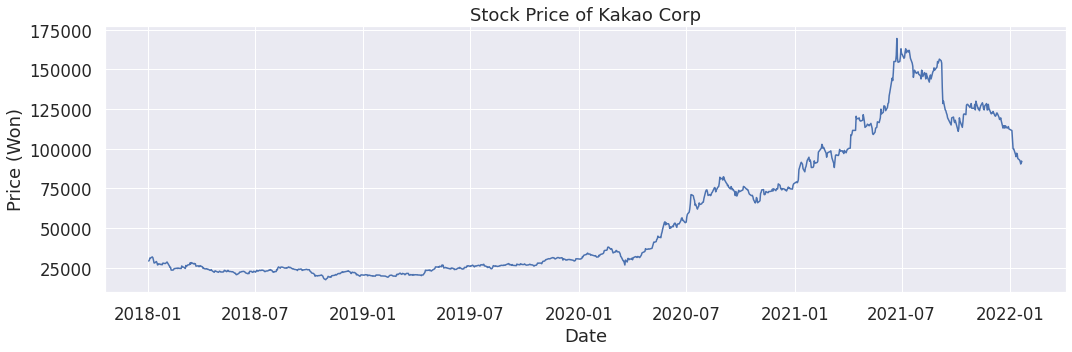

In [10]:
plt.figure(figsize=[15,5])
g1 = sns.lineplot(data = kko, x='Date', y='Close')
g1.set_ylabel('Price (Won)')
g1.set_xlabel('Date')
g1.set_title('Stock Price of Kakao Corp')
plt.tight_layout()
plt.show()

In [11]:
df_kko = deepcopy(kko.reset_index())
df_exr = ExRate.reset_index()[['Date', 'Close']]
df_exr.rename(columns={'Close':'exr'}, inplace=True)
df_tlt = tlt.reset_index()[['Date', 'Close']]
df_tlt.rename(columns={'Close':'tlt'}, inplace=True)
df_kospi = kospi.reset_index()[['Date', 'Close']]
df_kospi.rename(columns={'Close':'kospi'}, inplace=True)
df_nasdaq = nasdaq.reset_index()[['Date', 'Close']]
df_nasdaq.rename(columns={'Close':'nasdaq'}, inplace=True)


In [12]:
df_kko.shape, df_exr.shape, df_tlt.shape, df_kospi.shape, df_nasdaq.shape

((1000, 7), (1059, 2), (1022, 2), (1000, 2), (1022, 2))

* 날짜 차이에 의해 각 데이터들의 행 차이가 존재한다. Merge로 kakao에 outer 조인으로 통합시켜준다. 

In [13]:
df1 = pd.merge(left = df_kko, right = df_exr, how = 'left', on = 'Date')
df2 = pd.merge(left = df1, right = df_tlt, how = 'left', on = 'Date')
df3 = pd.merge(left = df2, right = df_kospi, how = 'left', on = 'Date')
df4 = pd.merge(left = df3, right = df_nasdaq, how = 'left', on = 'Date')

### Data Glimpse

In [14]:
df4.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,exr,tlt,kospi,nasdaq
0,2018-01-02,28000.0,29400.0,27900.0,29300.0,29225.353516,6729755,1065.219971,125.489998,2479.649902,7006.899902
1,2018-01-03,30100.0,30200.0,29100.0,29800.0,29724.078125,5771805,1062.540039,126.089996,2486.350098,7065.529785
2,2018-01-04,30500.0,31800.0,29900.0,31200.0,31120.511719,11325095,1063.939941,126.070000,2466.459961,7077.910156


In [15]:
df4.describe()

,Open,High,Low,Close,Adj Close,Volume,exr,tlt,kospi,nasdaq
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,999.000000,969.000000,1000.000000,969.000000
mean,57246.800000,58160.140000,56372.060000,57246.480000,57218.610332,3.404517e+06,1147.394787,139.068989,2448.373139,10062.044111
std,42238.035113,42895.499179,41584.792031,42195.110482,42211.957918,2.647530e+06,44.294131,16.381929,432.082936,2924.234003
min,17200.000000,18220.000000,17200.000000,17520.000000,17475.365234,0.000000e+00,1053.729980,112.000000,1457.640015,6192.919922
25%,24400.000000,24800.000000,24000.000000,24375.000000,24320.723145,1.697571e+06,1116.480042,121.970001,2111.505066,7688.390137
50%,31300.000000,31800.000000,30900.000000,31400.000000,31340.221680,2.581650e+06,1141.109985,139.500000,2300.159912,8567.370117
75%,89625.000000,91500.000000,87225.000000,88875.000000,88875.000000,4.201070e+06,1184.335022,150.529999,2922.669922,13031.679688
max,172000.000000,173000.000000,161000.000000,169500.000000,169500.000000,2.611002e+07,1262.930054,171.570007,3305.209961,16057.440430


In [16]:
print(df4.isnull().sum())

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
exr           1
tlt          31
kospi         0
nasdaq       31
dtype: int64


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


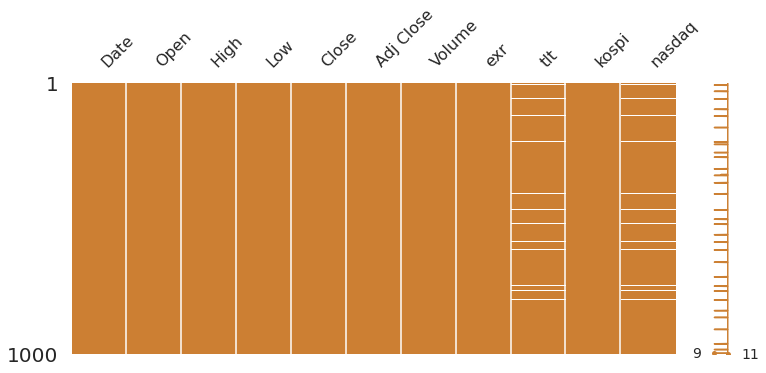

In [17]:
msno.matrix(df=df4, figsize=[12,5],color=(0.8, 0.5, 0.2))
plt.tight_layout()
plt.show()

* 각 feature들의 단위 차이가 크다 -> minmax scaler로 정규화해준다.
* 미국 시장과 국내 시장 간의 시장 기간 차이 때문에 몇몇 결측치가 보인다. -> Moving Averag를 활용, 전후 값을 활용하여 보간해준다.
* 그전에 데이터 셋을 분할하자

### Data Split

In [18]:
tmp_df = deepcopy(df4)
tmp_df = tmp_df.set_index('Date')
train_df = tmp_df[:'2021-8-01'].reset_index()
test_df = tmp_df['2021-8-01':].reset_index()

### EDA

* 모델 구성 전에 지표들 간의 어떠한 상관 관계가 있는지 확인해보자.

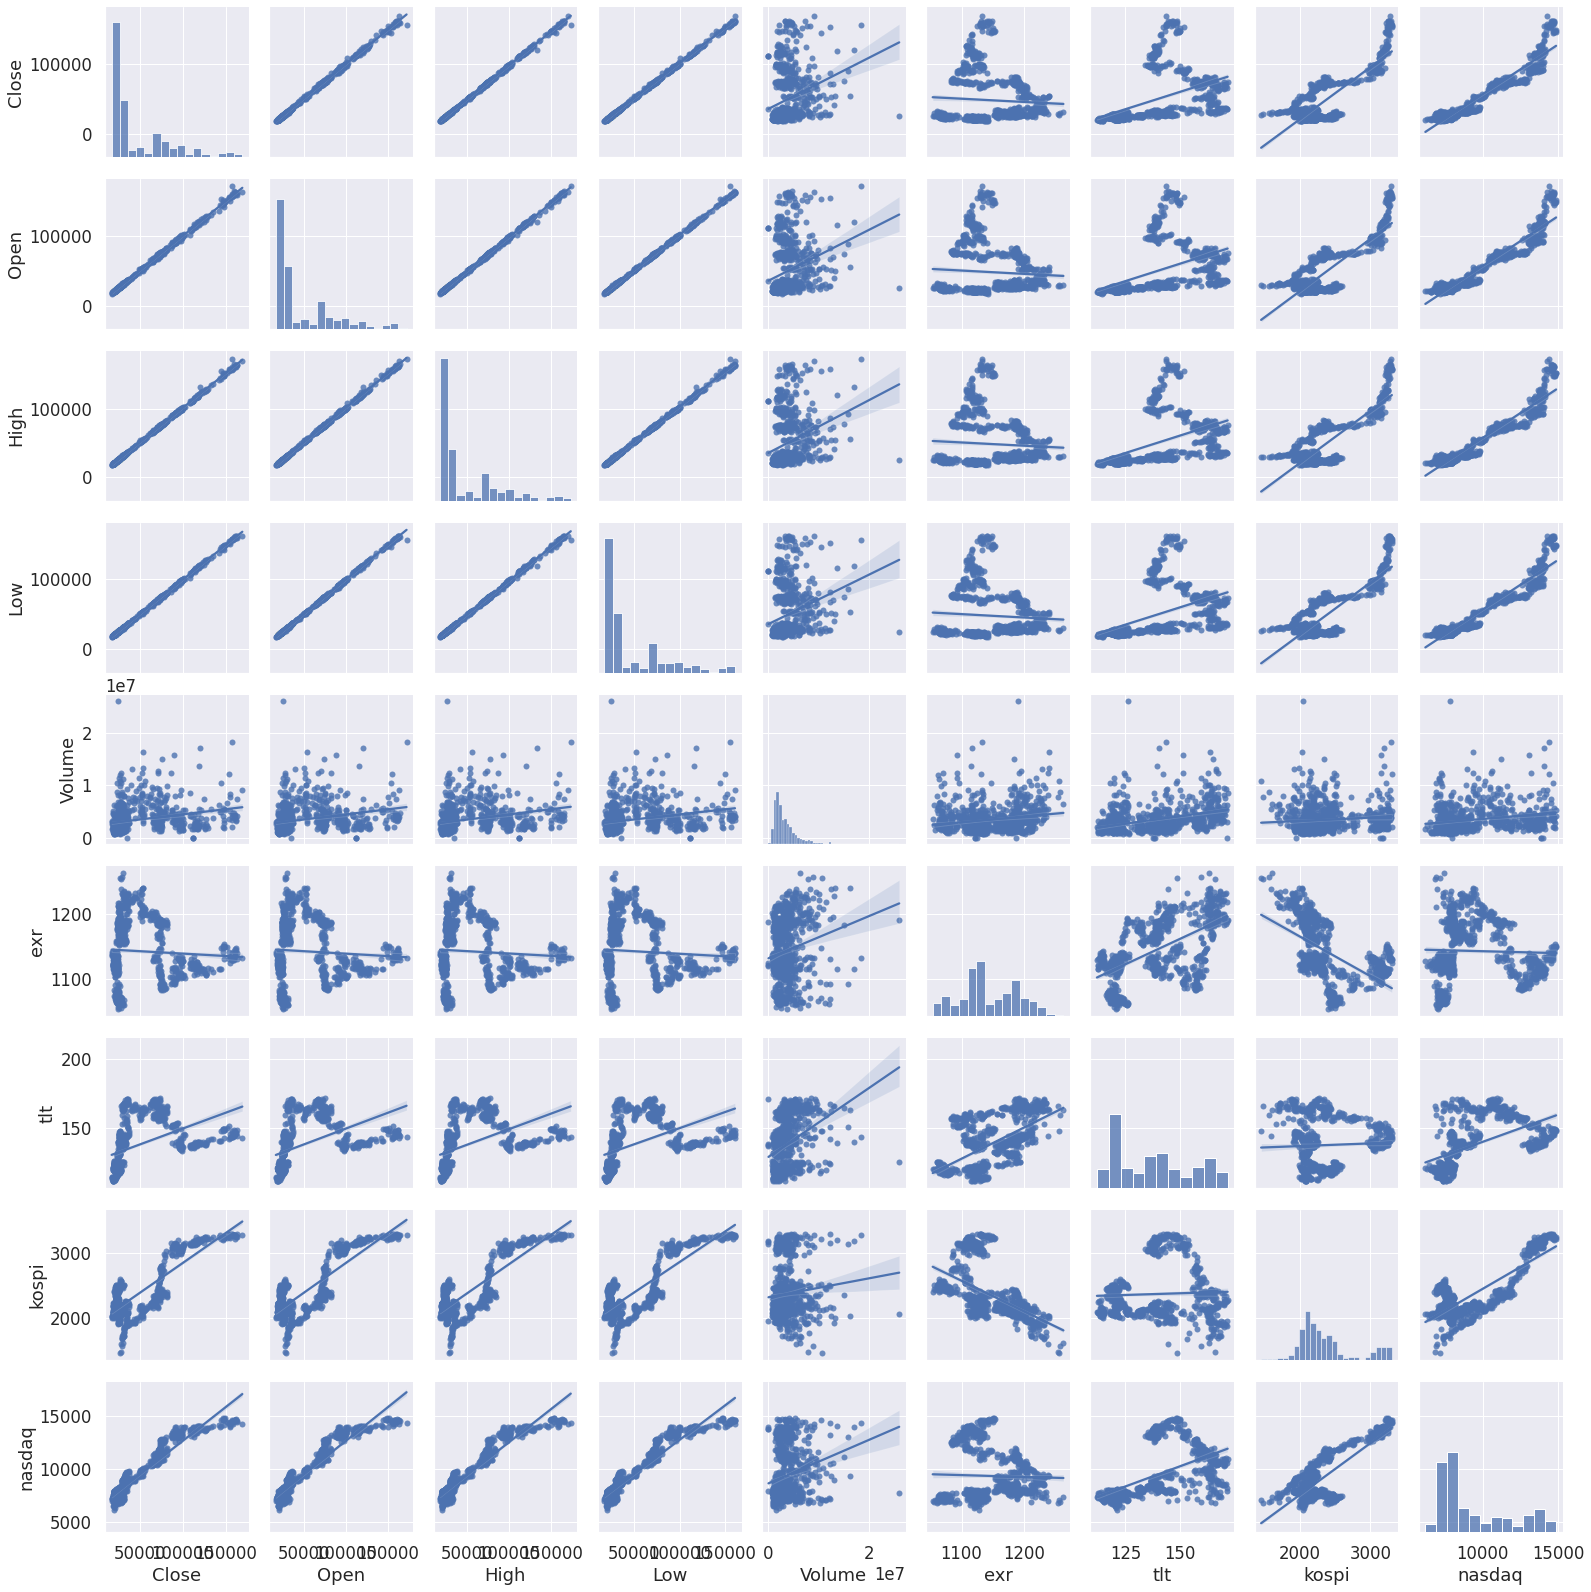

In [19]:
g1 = sns.pairplot(data=train_df[['Close','Open', 'High', 'Low','Volume','exr','tlt','kospi','nasdaq']], 
             kind = 'reg')
plt.show()



findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


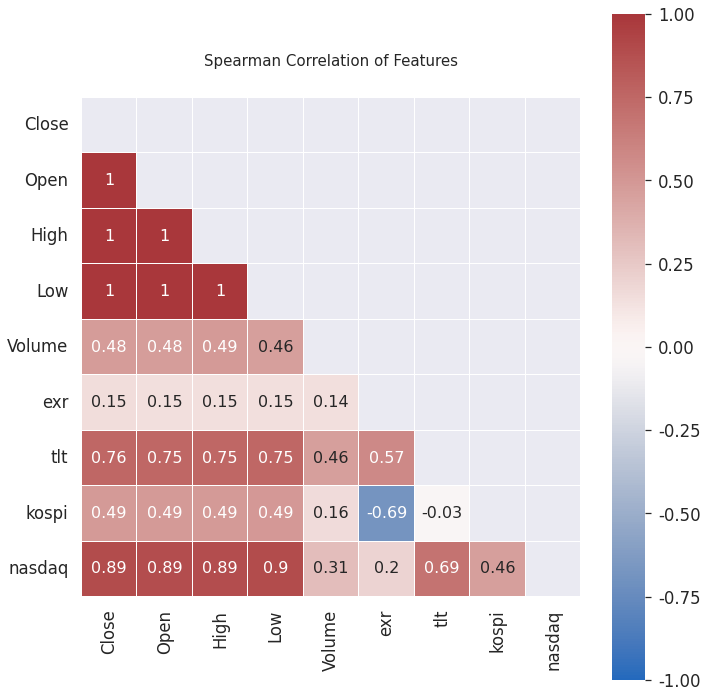

In [20]:
mask = np.zeros_like(train_df[['Close','Open', 'High', 'Low','Volume','exr','tlt','kospi','nasdaq']].corr(method="spearman"))
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.title("Spearman Correlation of Features", y=1.05, size=15)
g1= sns.heatmap(train_df[['Close','Open', 'High', 'Low','Volume','exr','tlt','kospi','nasdaq']].corr(method="spearman"),
                linewidths=0.1, vmax=1.0, vmin=-1.0, mask=mask,
                square=True, cmap= "vlag", linecolor='white', 
                annot=True, annot_kws={"size": 16},
               ax = ax)
plt.tight_layout()
plt.show()

* Low, High, Open은 종가와 높은 상관을 보인다. 이건 당연하다.
* kakao의 주가와 가장 높은 상관을 보인 것은 nasdaq이었다. 코로나 이후 nasdaq 증가세와 함께 주가가 오른 것으로 보인다. 

* min-max scaler로 단위를 변환한 후 시기별 그래프를 확인해본다. 

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Close','Open', 'High', 'Low','Volume','exr','tlt','kospi','nasdaq']
train_df_f = scaler.fit_transform(train_df[scale_cols])
train_df_f = pd.DataFrame(train_df_f)
train_df_f.columns = scale_cols
train_df_f = pd.concat([train_df['Date'], train_df_f], axis = 1)

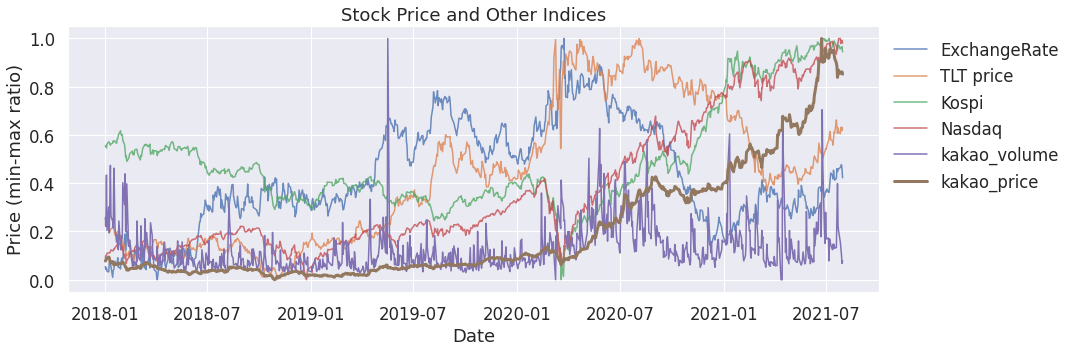

In [22]:
plt.figure(figsize=[15,5])
g1 = sns.lineplot(data = train_df_f, x='Date', y='exr', alpha =0.8)
g1 = sns.lineplot(data = train_df_f, x='Date', y='tlt', alpha =0.8)
g1 = sns.lineplot(data = train_df_f, x='Date', y='kospi', alpha =0.8)
g1 = sns.lineplot(data = train_df_f, x='Date', y='nasdaq', alpha =0.8)
g1 = sns.lineplot(data = train_df_f, x='Date', y='Volume', alpha = 1)
g1 = sns.lineplot(data = train_df_f, x='Date', y='Close', linewidth=3)

g1.set_ylabel('Price (min-max ratio)')
g1.set_xlabel('Date')
g1.set_title('Stock Price and Other Indices')
g1.legend(['ExchangeRate', 'TLT price', 'Kospi', 'Nasdaq','kakao_volume', 'kakao_price'], 
          bbox_to_anchor=(1.0, 1.0))

plt.tight_layout()
plt.show()

### Data Preprocessing

#### Handling NA values

* 먼저 결측치를 제거한다.

In [23]:
train_df_raw = deepcopy(train_df)
test_df_raw = deepcopy(test_df)

In [24]:
train_df.isnull().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
exr           1
tlt          27
kospi         0
nasdaq       27
dtype: int64

In [25]:
neg_idx = train_df[train_df['exr'].isnull()].index
tmp_col = deepcopy(train_df['exr'])
for i, j in enumerate(neg_idx):
    tmp_col[j] = np.mean([tmp_col[j-5], tmp_col[j-4], tmp_col[j-3], tmp_col[j-2], tmp_col[j-1], tmp_col[j+1]])
train_df['exr'] = tmp_col

neg_idx = train_df[train_df['tlt'].isnull()].index
tmp_col = deepcopy(train_df['tlt'])
for i, j in enumerate(neg_idx):
    tmp_col[j] = np.mean([tmp_col[j-5], tmp_col[j-4], tmp_col[j-3], tmp_col[j-2], tmp_col[j-1], tmp_col[j+1]])
train_df['tlt'] = tmp_col

neg_idx = train_df[train_df['nasdaq'].isnull()].index
tmp_col = deepcopy(train_df['nasdaq'])
for i, j in enumerate(neg_idx):
    tmp_col[j] = np.mean([tmp_col[j-5], tmp_col[j-4], tmp_col[j-3], tmp_col[j-2], tmp_col[j-1], tmp_col[j+1]])
train_df['nasdaq'] = tmp_col


In [26]:
train_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
exr          0
tlt          0
kospi        0
nasdaq       0
dtype: int64

In [27]:
test_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
exr          0
tlt          4
kospi        0
nasdaq       4
dtype: int64

In [28]:
neg_idx = test_df[test_df['exr'].isnull()].index
tmp_col = deepcopy(test_df['exr'])
for i, j in enumerate(neg_idx):
    tmp_col[j] = np.mean([tmp_col[j-5], tmp_col[j-4], tmp_col[j-3], tmp_col[j-2], tmp_col[j-1], tmp_col[j+1]])
test_df['exr'] = tmp_col

neg_idx = test_df[test_df['tlt'].isnull()].index
tmp_col = deepcopy(test_df['tlt'])
for i, j in enumerate(neg_idx):
    tmp_col[j] = np.mean([tmp_col[j-5], tmp_col[j-4], tmp_col[j-3], tmp_col[j-2], tmp_col[j-1], tmp_col[j+1]])
test_df['tlt'] = tmp_col

neg_idx = test_df[test_df['nasdaq'].isnull()].index
tmp_col = deepcopy(test_df['nasdaq'])
for i, j in enumerate(neg_idx):
    tmp_col[j] = np.mean([tmp_col[j-5], tmp_col[j-4], tmp_col[j-3], tmp_col[j-2], tmp_col[j-1], tmp_col[j+1]])
test_df['nasdaq'] = tmp_col


In [29]:
test_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
exr          0
tlt          0
kospi        0
nasdaq       0
dtype: int64

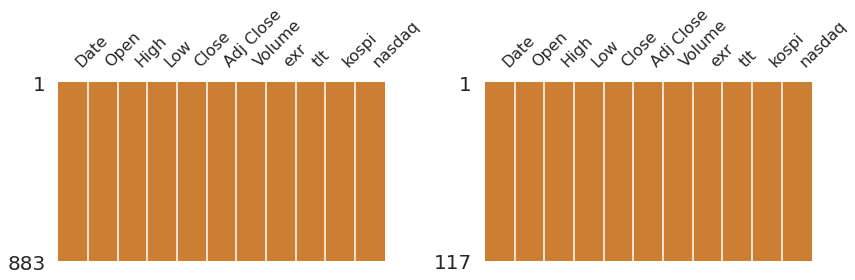

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
msno.matrix(df=train_df, color=(0.8, 0.5, 0.2), ax= ax[0])
msno.matrix(df=test_df, color=(0.8, 0.5, 0.2), ax= ax[1])
plt.tight_layout()
plt.show()

* 모든 결측치가 제거되었다.

#### Scaling

* Min-max scaler로 단위를 통일한다.

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Close','Open', 'High', 'Low','Volume','exr','tlt','kospi','nasdaq']
train_df_f = scaler.fit_transform(train_df[scale_cols])
train_df_f = pd.DataFrame(train_df_f)
train_df_f.columns = scale_cols
df_train = pd.concat([train_df['Date'], train_df_f], axis = 1)

test_df_f = scaler.transform(test_df[scale_cols])
test_df_f = pd.DataFrame(test_df_f)
test_df_f.columns = scale_cols
df_test = pd.concat([test_df['Date'], test_df_f], axis = 1)

### Modeling

#### Prepare Learing Set

In [32]:
target_y = df_train['Close']
target_x = df_train[['Close', 'Open', 'High', 'Low','Volume','exr','tlt','kospi','nasdaq']]

test_y = df_test['Close']
test_x = df_test[['Close', 'Open', 'High', 'Low','Volume','exr','tlt','kospi','nasdaq']]

* LSTM을 위한 연속형 데이터 분할을 준비한다

In [33]:
def make_dataset(data, label, window_size=10):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [34]:
window_size = 20
target_x, target_y = make_dataset(target_x, target_y, window_size=window_size)
test_x, test_y = make_dataset(test_x, test_y, window_size=window_size)

In [35]:
target_x.shape, target_y.shape, test_x.shape, test_y.shape,

((863, 20, 9), (863,), (97, 20, 9), (97,))

In [36]:
target_x[0][19], target_y[0], df_train.loc[19],  df_train.loc[20]

(array([0.06764048, 0.07105943, 0.06512469, 0.07301808, 0.13569733,
        0.04493318, 0.18012426, 0.61732436, 0.14727345]),
 0.0669824976970654,
 Date      2018-01-29 00:00:00
 Close               0.0676405
 Open                0.0710594
 High                0.0651247
 Low                 0.0730181
 Volume               0.135697
 exr                 0.0449332
 tlt                  0.180124
 kospi                0.617324
 nasdaq               0.147273
 Name: 19, dtype: object,
 Date      2018-01-30 00:00:00
 Close               0.0669825
 Open                0.0684755
 High                0.0638325
 Low                 0.0716273
 Volume               0.122979
 exr                 0.0767689
 tlt                  0.168038
 kospi                0.600843
 nasdaq               0.139869
 Name: 20, dtype: object)

* Validation Set을 준비한다. 

In [37]:
from sklearn import model_selection
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(target_x, target_y, test_size=0.2)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((690, 20, 9), (690,), (173, 20, 9), (173,))

In [38]:
x_test = test_x
y_test = test_y

#### Model Architecture

In [39]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

# model setting
model = keras.models.Sequential()
model.add(keras.layers.LSTM(16, 
               input_shape=(x_train.shape[1], x_train.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# callback setting
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')


#### Train & Validation

In [40]:
history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0681
Epoch 00001: val_loss improved from inf to 0.00899, saving model to model/tmp_checkpoint.h5
44/44 [==============================] - 2s 19ms/step - loss: 0.0667 - val_loss: 0.0090
Epoch 2/200
44/44 [==============================] - ETA: 0s - loss: 0.0031
Epoch 00002: val_loss improved from 0.00899 to 0.00088, saving model to model/tmp_checkpoint.h5
44/44 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 8.8072e-04
Epoch 3/200
40/44 [==========================>...] - ETA: 0s - loss: 6.9023e-04
Epoch 00003: val_loss improved from 0.00088 to 0.00041, saving model to model/tmp_checkpoint.h5
44/44 [==============================] - 0s 10ms/step - loss: 6.6017e-04 - val_loss: 4.0803e-04
Epoch 4/200
40/44 [==========================>...] - ETA: 0s - loss: 3.7571e-04
Epoch 00004: val_loss improved from 0.00041 to 0.00038, saving model to model/tmp_checkpoint.h5
44/44 [=========================

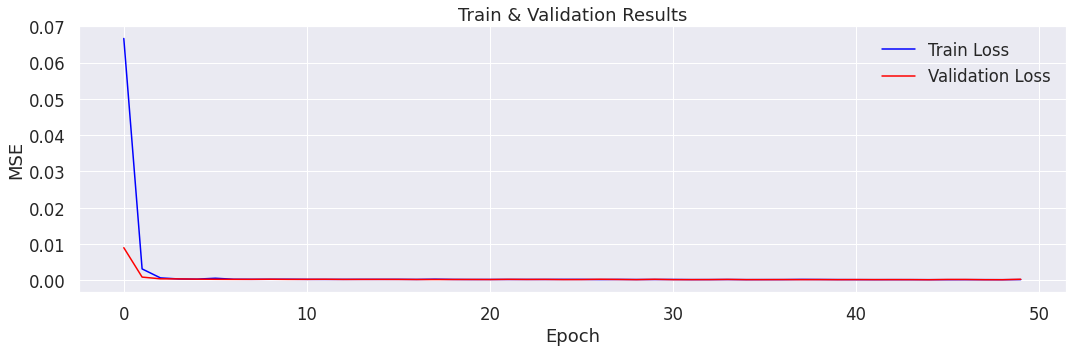

In [41]:
plt.figure(figsize=[15,5])
g1 = sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], color='blue')
g1 = sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], color='red')
g1.set_ylabel('MSE')
g1.set_xlabel('Epoch')
g1.set_title('Train & Validation Results')
g1.legend(['Train Loss', 'Validation Loss'], 
          bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

#### Prediction

In [42]:
model.load_weights(filename)
pred_y = model.predict(test_x)
pred_y.shape

(97, 1)

In [43]:
predicted = pd.concat([test_df.Date[window_size:].reset_index(), 
                       pd.DataFrame(test_y, columns=['y']), 
                       pd.DataFrame(pred_y, columns=['yhat'])], 
                      axis=1, ignore_index=True)

predicted.columns = ['idx','ds','y','yhat']

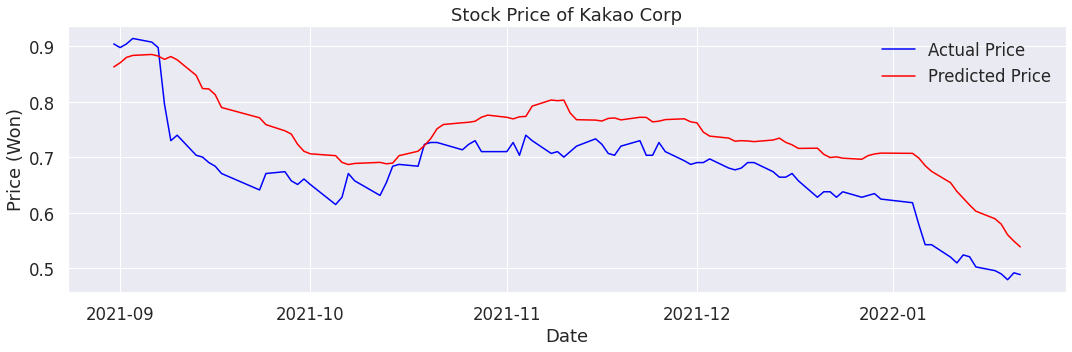

In [44]:
plt.figure(figsize=[15,5])
g1 = sns.lineplot(data = predicted, x='ds', y='y', color='blue')
g1 = sns.lineplot(data = predicted, x='ds', y='yhat', color='red')
g1.set_ylabel('Price (Won)')
g1.set_xlabel('Date')
g1.set_title('Stock Price of Kakao Corp')
g1.legend(['Actual Price', 'Predicted Price'], 
          bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

In [45]:
predicted

,idx,ds,y,yhat
0,20,2021-08-31,0.904593,0.863157
1,21,2021-09-01,0.898013,0.870542
2,22,2021-09-02,0.904593,0.880318
3,23,2021-09-03,0.914462,0.883913
4,24,2021-09-06,0.907883,0.885605
...,...,...,...,...
92,112,2022-01-17,0.495986,0.589520
93,113,2022-01-18,0.490064,0.579668
94,114,2022-01-19,0.479537,0.560559
95,115,2022-01-20,0.492038,0.549064


In [46]:
from sklearn import metrics
print('mse :', metrics.mean_squared_error(predicted.y, predicted.yhat))
print('mae :', metrics.mean_absolute_error(predicted.y, predicted.yhat))

# mse : 0.0017266956192354803
# mae : 0.0301069750329295

mse : 0.005661505057776847
mae : 0.06704272866637066


In [47]:
import pingouin as pg
pg.corr(predicted.y, predicted.yhat,
        alternative="two-sided",
        method="pearson") # pearson, spearman, kendall, bicor, percbend, shepherd, skipped

,n,r,CI95%,p-val,BF10,power
pearson,97,0.897806,"[0.85, 0.93]",1.325205e-35,1.75e+32,1.0


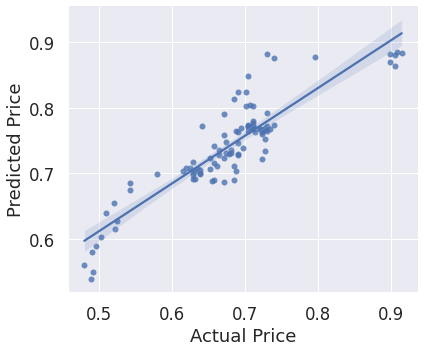

In [48]:
g = sns.lmplot(x="y", y="yhat", data=predicted, height=5, aspect=1.2);
g.set_axis_labels("Actual Price", "Predicted Price")
plt.tight_layout()
plt.show()

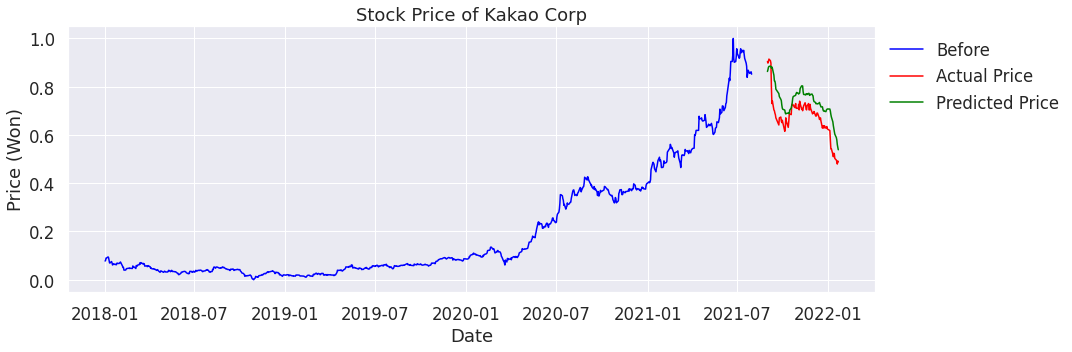

In [49]:
plt.figure(figsize=[15,5])
g1 = sns.lineplot(data = df_train, x='Date', y='Close', color='blue')
g1 = sns.lineplot(data = predicted, x='ds', y='y', color='red')
g1 = sns.lineplot(data = predicted, x='ds', y='yhat', color='green')
g1.set_ylabel('Price (Won)')
g1.set_xlabel('Date')
g1.set_title('Stock Price of Kakao Corp')
g1.legend(['Before', 'Actual Price', 'Predicted Price'], 
          bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()